In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords                
from nltk import word_tokenize, sent_tokenize

import keras
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, LSTM, SpatialDropout1D, Input, Bidirectional,Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

import os

/opt/anaconda/envs/bd9/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import zipfile
zip_file = zipfile.ZipFile('word2vec-nlp-tutorial.zip', 'r')
zip_file.extractall()
zip_file.close()

In [4]:
raw_train_data_labeled = pd.read_csv('labeledTrainData.tsv', header=0, delimiter="\t", quoting=3)
raw_train_data_unlabeled = pd.read_csv('unlabeledTrainData.tsv', header=0,  delimiter="\t", quoting=3)

raw_test_data = pd.read_csv('testData.tsv', header=0,  delimiter="\t", quoting=3)

In [18]:
imdb_data = pd.read_csv('imdb_master.csv', encoding="latin-1")
imdb_data.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [19]:
imdb_data = imdb_data.drop(["Unnamed: 0","type","file"],axis=1)
imdb_data['sentiment'] = imdb_data['label'].map({"neg":0, "pos":1})
imdb_data = imdb_data.drop(["label"],axis=1)
imdb_data = imdb_data.dropna()
imdb_data = imdb_data[['sentiment','review']]

In [20]:
raw_train_data_labeled.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [21]:
raw_train_data_unlabeled.head()

,id,review
0,"""9999_0""","""Watching Time Chasers, it obvious that it was..."
1,"""45057_0""","""I saw this film about 20 years ago and rememb..."
2,"""15561_0""","""Minor Spoilers<br /><br />In New York, Joan B..."
3,"""7161_0""","""I went to see this film with a great deal of ..."
4,"""43971_0""","""Yes, I agree with everyone on this site this ..."


In [22]:
X = raw_train_data_labeled['review']
y = raw_train_data_labeled['sentiment']

In [24]:
review_data = X.append(raw_test_data['review'])
review_data = review_data.append(imdb_data['review'])

In [25]:
review_data.shape

(100000,)

In [26]:
ntrain = X.shape[0]
df = raw_train_data_labeled.append(raw_test_data, sort=False)
df = df.drop(['sentiment'], axis=1)
df_review = df['review']

In [27]:
'''
1. Removing punctuations
2. Lowering all words
3. removing non-alphabet things
4. removing stop words
5. Tokenizing the sentence
'''
import string

review_lines = list()
lines = review_data.values.tolist()

for line in lines:
    
    tokens = word_tokenize(line)   
    
    #convert to lower case
    tokens = [w.lower() for w in tokens]
    
    #remove punctuation from each word
     table = str.maketrans('','', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
     
    # remove remaining tokens that are not alphabetic
    words = [w for w in stripped if w.isalpha()]
    
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words]
    
    review_lines.append(words)

In [28]:
import gensim

embedding_vector_size = 150
model_1 = gensim.models.Word2Vec(sentences = review_lines, size=embedding_vector_size, min_count=1, window=5, workers=4 )

# to get total number of unique words
words = list(model_1.wv.vocab)

print("vocab size:", len(words))

vocab size: 135605


Text(0,0.5,'frequency')

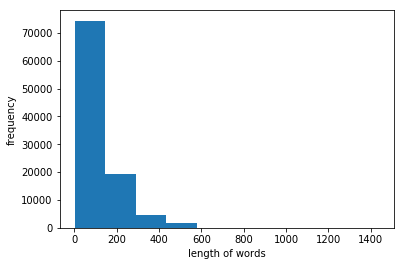

In [29]:
leng=0
length = [(leng + len(x)) for x in review_lines]
plt.hist(length)
plt.xlabel('length of words')
plt.ylabel('frequency')

In [30]:
import math
avg_length = sum(length)/len(review_lines)

# if words are more than max_length then they are skipped, if less than padding with 0 is done
print(avg_length)

max_len = math.ceil(avg_length) 

122.11881


In [31]:
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)       #keeps 6000 most common words
train_test_data = review_lines                       # contains word tokens extracted from lines
tokenizer.fit_on_texts(train_test_data)
sequence = tokenizer.texts_to_sequences(train_test_data)
train_test_data = pad_sequences(sequence, maxlen = max_len)

In [32]:
# Preparing embedding matrix
vocab_size = len(tokenizer.word_index)+1
embedding_matrix = np.zeros((vocab_size, embedding_vector_size))
# +1 is done because i starts from 1 instead of 0, and goes till len(vocab)
for  word, i in tokenizer.word_index.items():
    embedding_vector = model_1.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [33]:
X = train_test_data[:ntrain,:]
X = np.append(X,train_test_data[ntrain+25000: ,:])
X = X.reshape(-1,123)
y1 = y.append(imdb_data['sentiment'])

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=42, shuffle=True)

In [35]:
model = Sequential()

model.add(Embedding(input_dim = vocab_size, output_dim = embedding_vector_size, 
                    input_length = max_len, weights = [embedding_matrix]))
model.add(Bidirectional(LSTM(64, dropout=0.25, recurrent_dropout=0.1)))
model.add(Dense(10))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [36]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [37]:
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

history = model.fit(X_train, y_train, epochs = 30, batch_size = 700, validation_data=(X_test, y_test),callbacks = [learning_rate_reduction])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 123, 150)          20340900  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               110080    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 20,452,281
Trainable params: 20,452,281
Non-trainable params: 0
_________________________________________________________________
None
Train on 60000 samples, validate on 15000 samples
Epoch 1/30
60000/60000 [==============================] - 315s 5ms/step - l

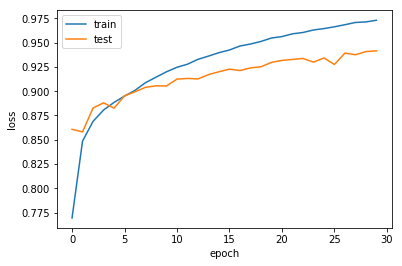

In [38]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
y_test_pred = model.predict(X_test)

In [40]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_test_pred, average = 'weighted')

0.9804726922484799

In [43]:
#predicting test_data
y_pred = model.predict(train_test_data[ntrain:ntrain+25000 , :])


In [52]:
predictions = [1 if (x>0.99) else 0 for x in y_pred ]
predictions = pd.Series(predictions)

In [53]:
ids = raw_test_data['id'].str.replace('"', '')

In [54]:
submission = pd.DataFrame({'id': ids, 'sentiment':predictions})
submission.to_csv('~/word2vec.csv',index=False)